# Paper 1: Regularization Effectiveness Study
## Autoren: Katrin Nguyen & Nico Loss

## Import & Setup

In [48]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings
from ydata_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning

from scipy.stats import ttest_rel

# Warnungen unterdrücken
warnings.filterwarnings('ignore', category=ConvergenceWarning)

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

Path("Reports").mkdir(exist_ok=True)
Path("Save").mkdir(exist_ok=True)



## Data Loading
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/shivam2503/diamonds

In [49]:
path = kagglehub.dataset_download("shivam2503/diamonds")

print("Path to dataset files:", path)

df = pd.read_csv(path + "\\diamonds.csv")

df.drop(columns=["Unnamed: 0"], inplace=True) # Fehlerhafte Index Column entfernen

Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\shivam2503\diamonds\versions\1


## Data Exploration

In [50]:
print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None

First 5 rows:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  

## Automatisches Reporting erstellen

In [51]:
profile = ProfileReport(df, title="Analyse Diamond Report", explorative=True)
profile.to_file("Reports\\DiamonAnalyses_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 81.95it/s]


## Explorative Data Analysis


EXPLORATORY DATA ANALYSIS


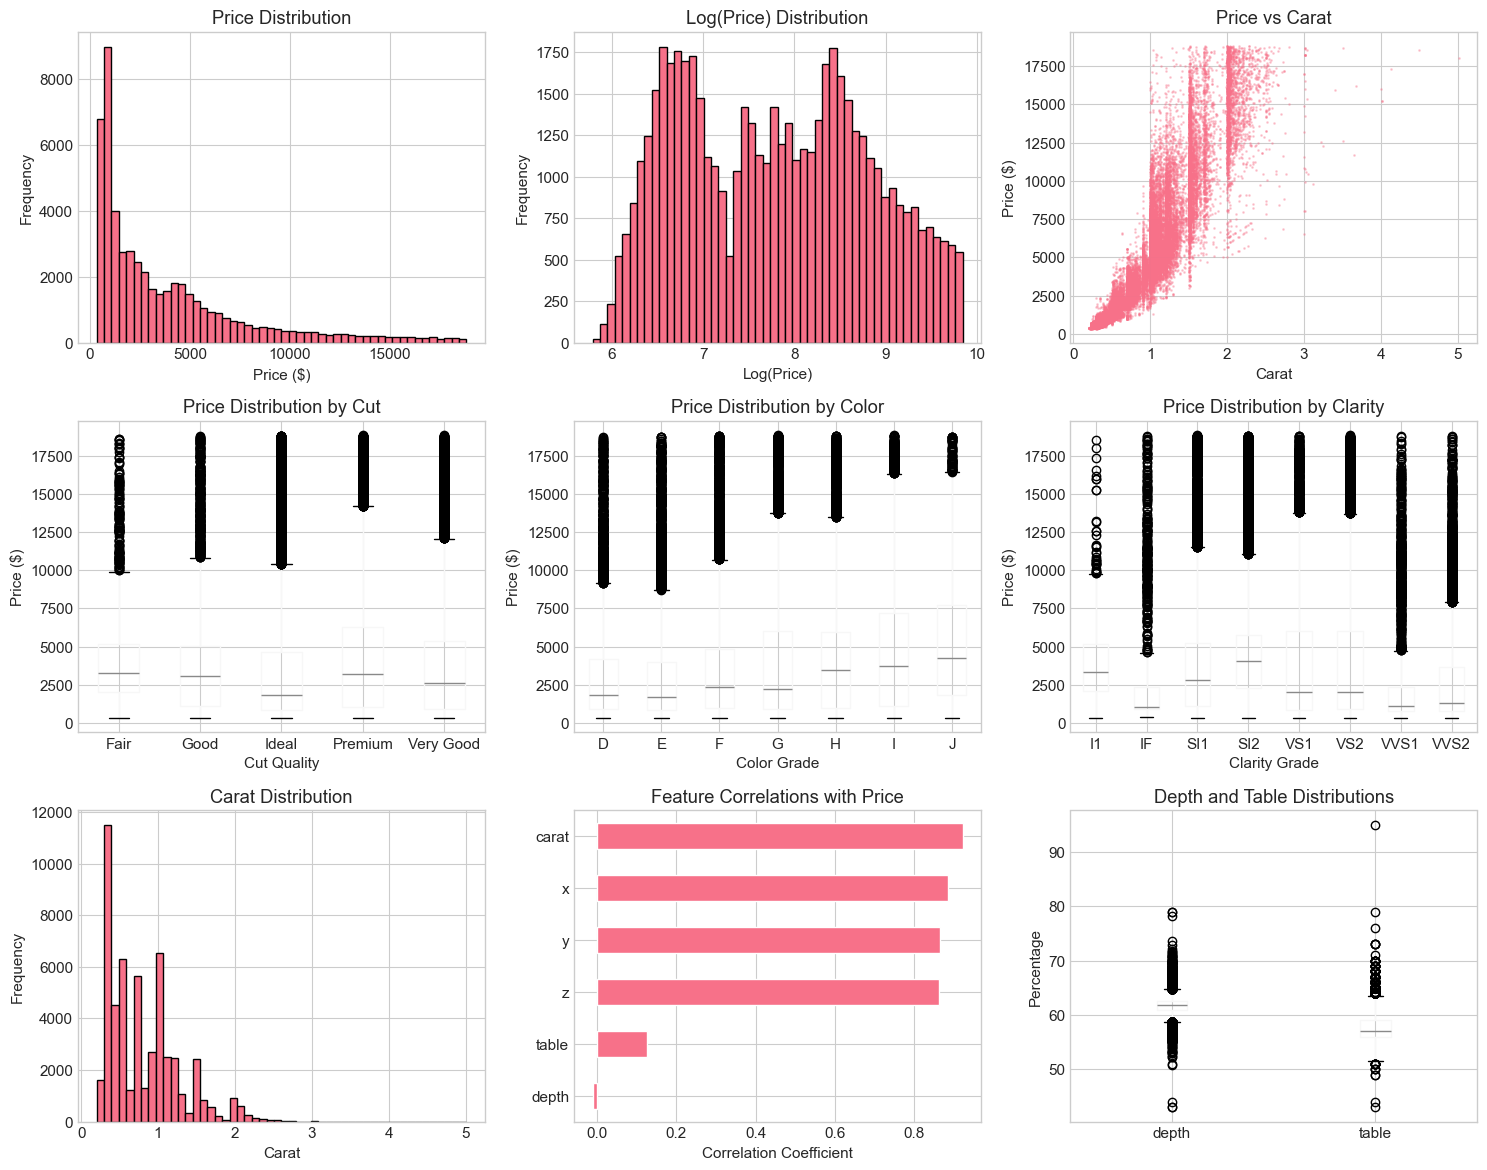

In [52]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create figure for EDA plots
fig = plt.figure(figsize=(15, 12))

# 1. Price distribution
ax1 = plt.subplot(3, 3, 1)
df['price'].hist(bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# 2. Log-transformed price distribution
ax2 = plt.subplot(3, 3, 2)
np.log1p(df['price']).hist(bins=50, edgecolor='black')
plt.title('Log(Price) Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# 3. Price vs Carat
ax3 = plt.subplot(3, 3, 3)
plt.scatter(df['carat'], df['price'], alpha=0.3, s=1)
plt.title('Price vs Carat')
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# 4. Price by Cut
ax4 = plt.subplot(3, 3, 4)
df.boxplot(column='price', by='cut', ax=ax4)
plt.title('Price Distribution by Cut')
plt.suptitle('')
plt.xlabel('Cut Quality')
plt.ylabel('Price ($)')

# 5. Price by Color
ax5 = plt.subplot(3, 3, 5)
df.boxplot(column='price', by='color', ax=ax5)
plt.title('Price Distribution by Color')
plt.suptitle('')
plt.xlabel('Color Grade')
plt.ylabel('Price ($)')

# 6. Price by Clarity
ax6 = plt.subplot(3, 3, 6)
df.boxplot(column='price', by='clarity', ax=ax6)
plt.title('Price Distribution by Clarity')
plt.suptitle('')
plt.xlabel('Clarity Grade')
plt.ylabel('Price ($)')

# 7. Carat distribution
ax7 = plt.subplot(3, 3, 7)
df['carat'].hist(bins=50, edgecolor='black')
plt.title('Carat Distribution')
plt.xlabel('Carat')
plt.ylabel('Frequency')

# 8. Correlation with price
ax8 = plt.subplot(3, 3, 8)
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
correlations = df[numeric_cols + ['price']].corr()['price'].drop('price').sort_values()
correlations.plot(kind='barh')
plt.title('Feature Correlations with Price')
plt.xlabel('Correlation Coefficient')

# 9. Feature distributions
ax9 = plt.subplot(3, 3, 9)
df[['depth', 'table']].boxplot(ax=ax9)
plt.title('Depth and Table Distributions')
plt.ylabel('Percentage')

plt.tight_layout()
plt.savefig('Save\\eda_diamonds.png', dpi=300, bbox_inches='tight')
plt.show()

## Data Preprocessing


DATA PREPROCESSING
Initial dataset size: 53940
After removing zero dimensions: 53920
After removing outliers: 53917

Feature Engineering:
- Added: volume, carat_squared, xy_ratio, depth_table_ratio

Final dataset shape: X=(53917, 13), y=(53917,)
Features used: ['carat', 'cut_encoded', 'color_encoded', 'clarity_encoded', 'depth', 'table', 'x', 'y', 'z', 'volume', 'carat_squared', 'xy_ratio', 'depth_table_ratio']


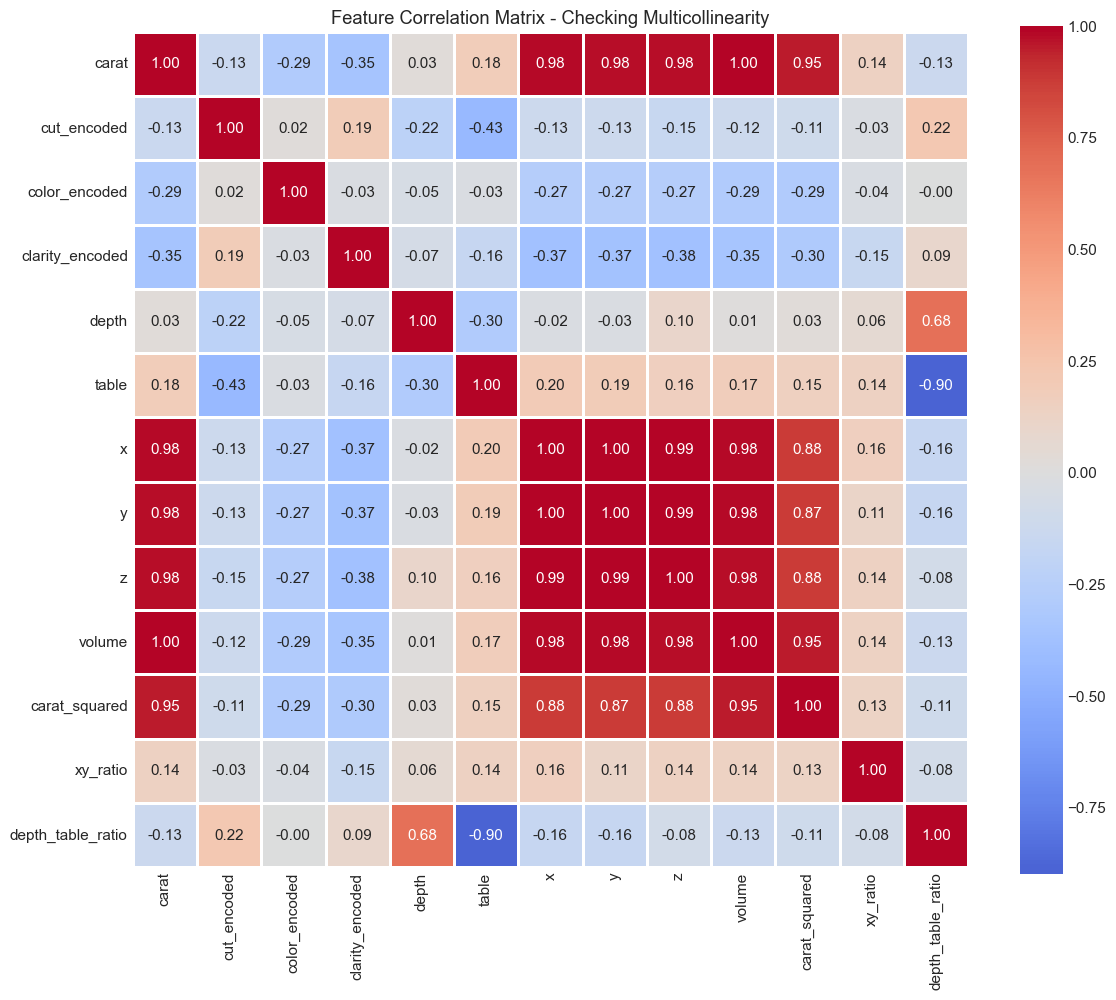


Highly correlated feature pairs (|r| > 0.8):
  carat <-> x: 0.978
  carat <-> y: 0.977
  carat <-> z: 0.976
  carat <-> volume: 0.999
  carat <-> carat_squared: 0.953
  table <-> depth_table_ratio: -0.898
  x <-> y: 0.999
  x <-> z: 0.991
  x <-> volume: 0.979
  x <-> carat_squared: 0.876
  y <-> z: 0.991
  y <-> volume: 0.979
  y <-> carat_squared: 0.875
  z <-> volume: 0.976
  z <-> carat_squared: 0.875
  volume <-> carat_squared: 0.952


In [53]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Remove diamonds with zero dimensions
print(f"Initial dataset size: {len(df)}")
df_clean = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)].copy()
print(f"After removing zero dimensions: {len(df_clean)}")

# Remove extreme outliers (unrealistic measurements)
# Using IQR method for dimensions
for col in ['x', 'y', 'z']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"After removing outliers: {len(df_clean)}")

# Ordinal encoding for categorical variables
cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

df_clean['cut_encoded'] = df_clean['cut'].map(cut_mapping)
df_clean['color_encoded'] = df_clean['color'].map(color_mapping)
df_clean['clarity_encoded'] = df_clean['clarity'].map(clarity_mapping)

# Feature engineering
print("\nFeature Engineering:")
df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']
df_clean['carat_squared'] = df_clean['carat'] ** 2
df_clean['xy_ratio'] = df_clean['x'] / df_clean['y']
df_clean['depth_table_ratio'] = df_clean['depth'] / df_clean['table']
print("- Added: volume, carat_squared, xy_ratio, depth_table_ratio")

# Prepare features and target
feature_cols = ['carat', 'cut_encoded', 'color_encoded', 'clarity_encoded',
                'depth', 'table', 'x', 'y', 'z', 'volume', 'carat_squared',
                'xy_ratio', 'depth_table_ratio']

X = df_clean[feature_cols].values
y = df_clean['price'].values

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")
print(f"Features used: {feature_cols}")

# Check for multicollinearity
correlation_matrix = df_clean[feature_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=1)
plt.title('Feature Correlation Matrix - Checking Multicollinearity')
plt.tight_layout()
plt.savefig('Save\\correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i],
                                   correlation_matrix.columns[j],
                                   correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

## Train-Validation-Test Split

In [54]:
print("\n" + "="*50)
print("DATA SPLITTING")
print("="*50)

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2 total
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling (fit on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler (fitted on training set only)")


DATA SPLITTING
Training set: 32349 samples
Validation set: 10784 samples
Test set: 10784 samples

Features scaled using StandardScaler (fitted on training set only)


## Baseline-Model

In [55]:
print("\n" + "="*50)
print("BASELINE MODEL - ORDINARY LEAST SQUARES")
print("="*50)

# Train baseline model
baseline = LinearRegression()
baseline.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_baseline = baseline.predict(X_train_scaled)
y_val_pred_baseline = baseline.predict(X_val_scaled)
y_test_pred_baseline = baseline.predict(X_test_scaled)

# Evaluate baseline
baseline_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_baseline),
    'Val R²': r2_score(y_val, y_val_pred_baseline),
    'Test R²': r2_score(y_test, y_test_pred_baseline),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_baseline)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_baseline)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_baseline)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_baseline),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_baseline),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_baseline)
}

print("\nBaseline Performance:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

train_test_gap = baseline_metrics['Train R²'] - baseline_metrics['Test R²']
print(f"\nTrain-Test R² Gap: {train_test_gap:.4f}")
if train_test_gap > 0.05:
    print("  → Indication of overfitting")


BASELINE MODEL - ORDINARY LEAST SQUARES

Baseline Performance:
  Train R²: 0.9203
  Val R²: 0.9176
  Test R²: 0.9218
  Train RMSE: 1124.9476
  Val RMSE: 1151.2801
  Test RMSE: 1110.4724
  Train MAE: 753.4124
  Val MAE: 764.3479
  Test MAE: 740.0122

Train-Test R² Gap: -0.0014


## Ridge Regression

In [56]:
print("\n" + "="*50)
print("RIDGE REGRESSION (L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_ridge = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {ridge_cv.alpha_:.6f}")

# Train final Ridge model
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_best.predict(X_train_scaled)
y_val_pred_ridge = ridge_best.predict(X_val_scaled)
y_test_pred_ridge = ridge_best.predict(X_test_scaled)

# Evaluate Ridge
ridge_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_ridge),
    'Val R²': r2_score(y_val, y_val_pred_ridge),
    'Test R²': r2_score(y_test, y_test_pred_ridge),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_ridge)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_ridge),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_ridge),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_ridge)
}

print("\nRidge Performance:")
for metric, value in ridge_metrics.items():
    print(f"  {metric}: {value:.4f}")


RIDGE REGRESSION (L2 REGULARIZATION)
Optimal alpha: 0.002024

Ridge Performance:
  Train R²: 0.9203
  Val R²: 0.9176
  Test R²: 0.9218
  Train RMSE: 1124.9477
  Val RMSE: 1151.2129
  Test RMSE: 1110.4037
  Train MAE: 753.4110
  Val MAE: 764.3395
  Test MAE: 740.0015


## Lasso Regression

In [57]:
print("\n" + "="*50)
print("LASSO REGRESSION (L1 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_lasso = np.logspace(-4, 2, 50)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Train final Lasso model
lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso_best.predict(X_train_scaled)
y_val_pred_lasso = lasso_best.predict(X_val_scaled)
y_test_pred_lasso = lasso_best.predict(X_test_scaled)

# Evaluate Lasso
lasso_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_lasso),
    'Val R²': r2_score(y_val, y_val_pred_lasso),
    'Test R²': r2_score(y_test, y_test_pred_lasso),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_lasso)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_lasso),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_lasso),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_lasso)
}

print("\nLasso Performance:")
for metric, value in lasso_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Feature selection analysis
n_features_selected = np.sum(lasso_best.coef_ != 0)
print(f"\nFeatures selected by Lasso: {n_features_selected}/{len(feature_cols)}")
print("Selected features:")
for i, (feature, coef) in enumerate(zip(feature_cols, lasso_best.coef_)):
    if coef != 0:
        print(f"  {feature}: {coef:.4f}")


LASSO REGRESSION (L1 REGULARIZATION)
Optimal alpha: 0.002947

Lasso Performance:
  Train R²: 0.9197
  Val R²: 0.9187
  Test R²: 0.9230
  Train RMSE: 1129.2103
  Val RMSE: 1143.3068
  Test RMSE: 1101.9469
  Train MAE: 756.7698
  Val MAE: 765.5607
  Test MAE: 740.9620

Features selected by Lasso: 13/13
Selected features:
  carat: 5790.3697
  cut_encoded: 111.2388
  color_encoded: 559.0778
  clarity_encoded: 773.9060
  depth: 251.8865
  table: -231.0087
  x: -14806.2627
  y: 11773.6933
  z: -3205.7893
  volume: 7589.8266
  carat_squared: -3382.1202
  xy_ratio: 559.8798
  depth_table_ratio: -264.4664


## Elastic Net

In [58]:
print("\n" + "="*50)
print("ELASTIC NET (L1 + L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_elastic = np.logspace(-4, 2, 30)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
elastic_cv = ElasticNetCV(
    alphas=alphas_elastic,
    l1_ratio=l1_ratios,
    cv=5,
    max_iter=10000,
    random_state=42
)
elastic_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {elastic_cv.alpha_:.6f}")
print(f"Optimal l1_ratio: {elastic_cv.l1_ratio_:.2f}")

# Train final ElasticNet model
elastic_best = ElasticNet(
    alpha=elastic_cv.alpha_,
    l1_ratio=elastic_cv.l1_ratio_,
    max_iter=10000
)
elastic_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_elastic = elastic_best.predict(X_train_scaled)
y_val_pred_elastic = elastic_best.predict(X_val_scaled)
y_test_pred_elastic = elastic_best.predict(X_test_scaled)

# Evaluate ElasticNet
elastic_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_elastic),
    'Val R²': r2_score(y_val, y_val_pred_elastic),
    'Test R²': r2_score(y_test, y_test_pred_elastic),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_elastic)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_elastic)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_elastic)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_elastic),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_elastic),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_elastic)
}

print("\nElasticNet Performance:")
for metric, value in elastic_metrics.items():
    print(f"  {metric}: {value:.4f}")


ELASTIC NET (L1 + L2 REGULARIZATION)
Optimal alpha: 0.000100
Optimal l1_ratio: 0.90

ElasticNet Performance:
  Train R²: 0.9196
  Val R²: 0.9187
  Test R²: 0.9229
  Train RMSE: 1130.0602
  Val RMSE: 1143.7540
  Test RMSE: 1102.2130
  Train MAE: 757.5011
  Val MAE: 766.0908
  Test MAE: 741.4704


## Model Comparison

In [59]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = {
    'OLS': baseline_metrics,
    'Ridge': ridge_metrics,
    'Lasso': lasso_metrics,
    'ElasticNet': elastic_metrics
}

comparison_df = pd.DataFrame(comparison_data).T
print("\nPerformance Comparison Table:")
print(comparison_df.round(4))

# Calculate improvements over baseline
print("\nImprovement over OLS (Test R²):")
for model in ['Ridge', 'Lasso', 'ElasticNet']:
    improvement = comparison_df.loc[model, 'Test R²'] - comparison_df.loc['OLS', 'Test R²']
    pct_improvement = (improvement / comparison_df.loc['OLS', 'Test R²']) * 100
    print(f"  {model}: {improvement:.4f} ({pct_improvement:.2f}%)")

# Train-Test Gap Analysis
print("\nTrain-Test R² Gap (Overfitting Analysis):")
for model in comparison_df.index:
    gap = comparison_df.loc[model, 'Train R²'] - comparison_df.loc[model, 'Test R²']
    print(f"  {model}: {gap:.4f}")


MODEL COMPARISON

Performance Comparison Table:
            Train R²  Val R²  Test R²  Train RMSE   Val RMSE  Test RMSE  \
OLS           0.9203  0.9176   0.9218   1124.9476  1151.2801  1110.4724   
Ridge         0.9203  0.9176   0.9218   1124.9477  1151.2129  1110.4037   
Lasso         0.9197  0.9187   0.9230   1129.2103  1143.3068  1101.9469   
ElasticNet    0.9196  0.9187   0.9229   1130.0602  1143.7540  1102.2130   

            Train MAE   Val MAE  Test MAE  
OLS          753.4124  764.3479  740.0122  
Ridge        753.4110  764.3395  740.0015  
Lasso        756.7698  765.5607  740.9620  
ElasticNet   757.5011  766.0908  741.4704  

Improvement over OLS (Test R²):
  Ridge: 0.0000 (0.00%)
  Lasso: 0.0012 (0.13%)
  ElasticNet: 0.0012 (0.13%)

Train-Test R² Gap (Overfitting Analysis):
  OLS: -0.0014
  Ridge: -0.0015
  Lasso: -0.0032
  ElasticNet: -0.0033


## Visualizations


GENERATING VISUALIZATIONS


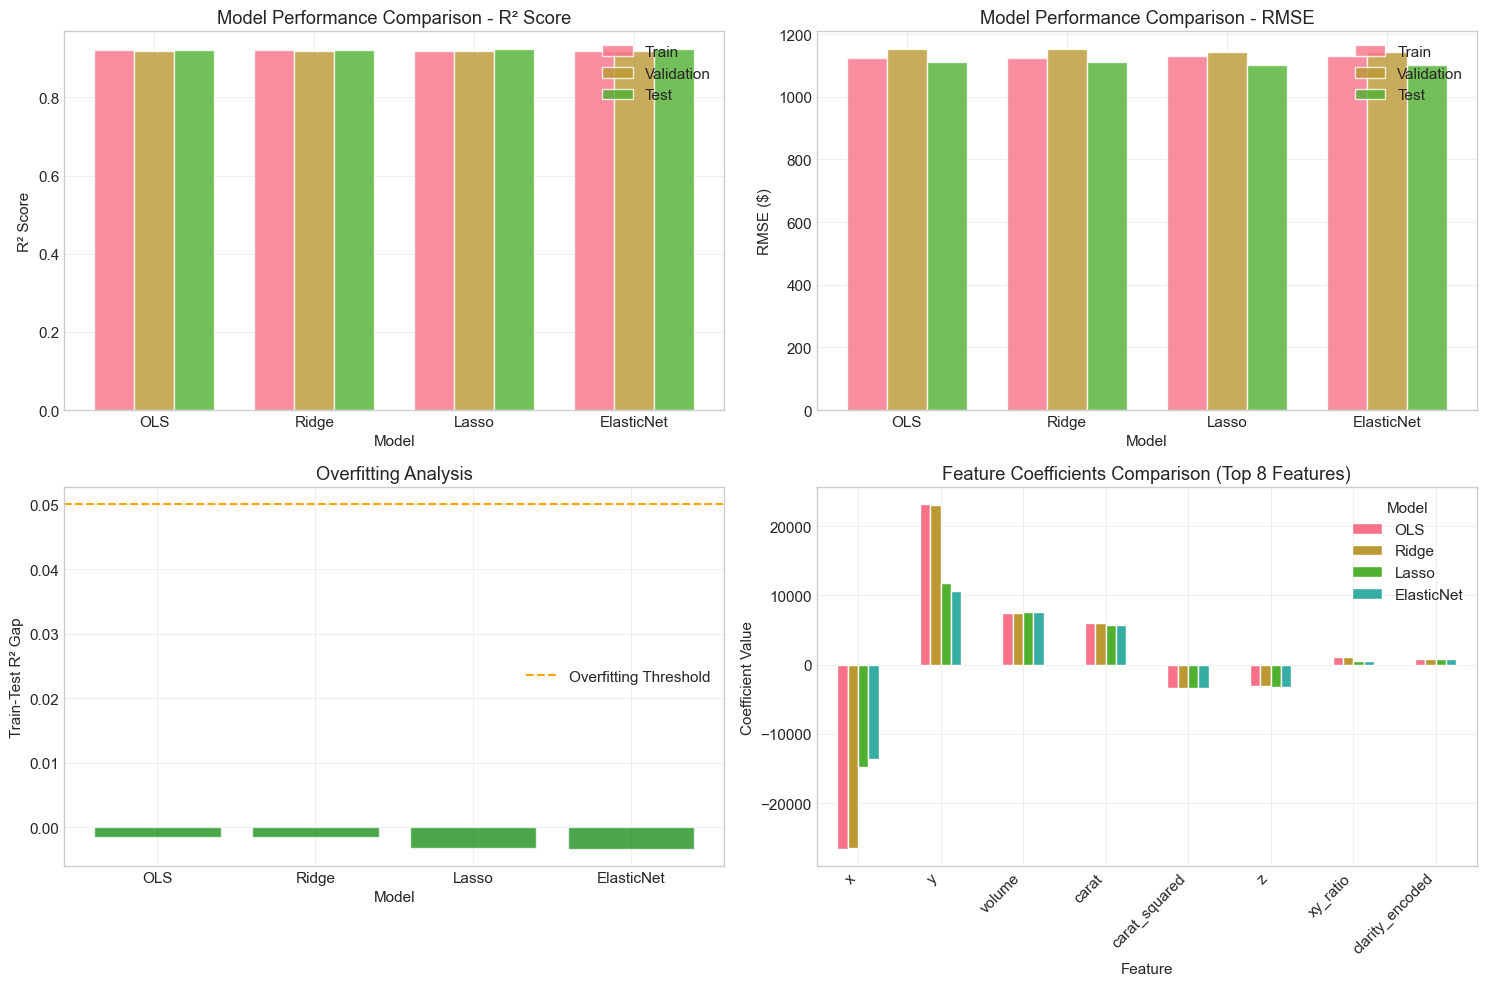

In [60]:
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# 1. Model Comparison Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Comparison
ax1 = axes[0, 0]
models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
train_r2 = [comparison_df.loc[m, 'Train R²'] for m in models]
val_r2 = [comparison_df.loc[m, 'Val R²'] for m in models]
test_r2 = [comparison_df.loc[m, 'Test R²'] for m in models]

x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, train_r2, width, label='Train', alpha=0.8)
ax1.bar(x, val_r2, width, label='Validation', alpha=0.8)
ax1.bar(x + width, test_r2, width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison - R² Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE Comparison
ax2 = axes[0, 1]
train_rmse = [comparison_df.loc[m, 'Train RMSE'] for m in models]
val_rmse = [comparison_df.loc[m, 'Val RMSE'] for m in models]
test_rmse = [comparison_df.loc[m, 'Test RMSE'] for m in models]

ax2.bar(x - width, train_rmse, width, label='Train', alpha=0.8)
ax2.bar(x, val_rmse, width, label='Validation', alpha=0.8)
ax2.bar(x + width, test_rmse, width, label='Test', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Model Performance Comparison - RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Train-Test Gap
ax3 = axes[1, 0]
gaps = [comparison_df.loc[m, 'Train R²'] - comparison_df.loc[m, 'Test R²'] for m in models]
colors = ['red' if g > 0.05 else 'green' for g in gaps]
ax3.bar(models, gaps, color=colors, alpha=0.7)
ax3.axhline(y=0.05, color='orange', linestyle='--', label='Overfitting Threshold')
ax3.set_xlabel('Model')
ax3.set_ylabel('Train-Test R² Gap')
ax3.set_title('Overfitting Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Feature Coefficients
ax4 = axes[1, 1]
coef_data = pd.DataFrame({
    'OLS': baseline.coef_,
    'Ridge': ridge_best.coef_,
    'Lasso': lasso_best.coef_,
    'ElasticNet': elastic_best.coef_
}, index=feature_cols)

# Plot only most important features
important_features = coef_data.abs().max(axis=1).nlargest(8).index
coef_data.loc[important_features].plot(kind='bar', ax=ax4)
ax4.set_xlabel('Feature')
ax4.set_ylabel('Coefficient Value')
ax4.set_title('Feature Coefficients Comparison (Top 8 Features)')
ax4.legend(title='Model')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Save\\model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Generating learning curves...


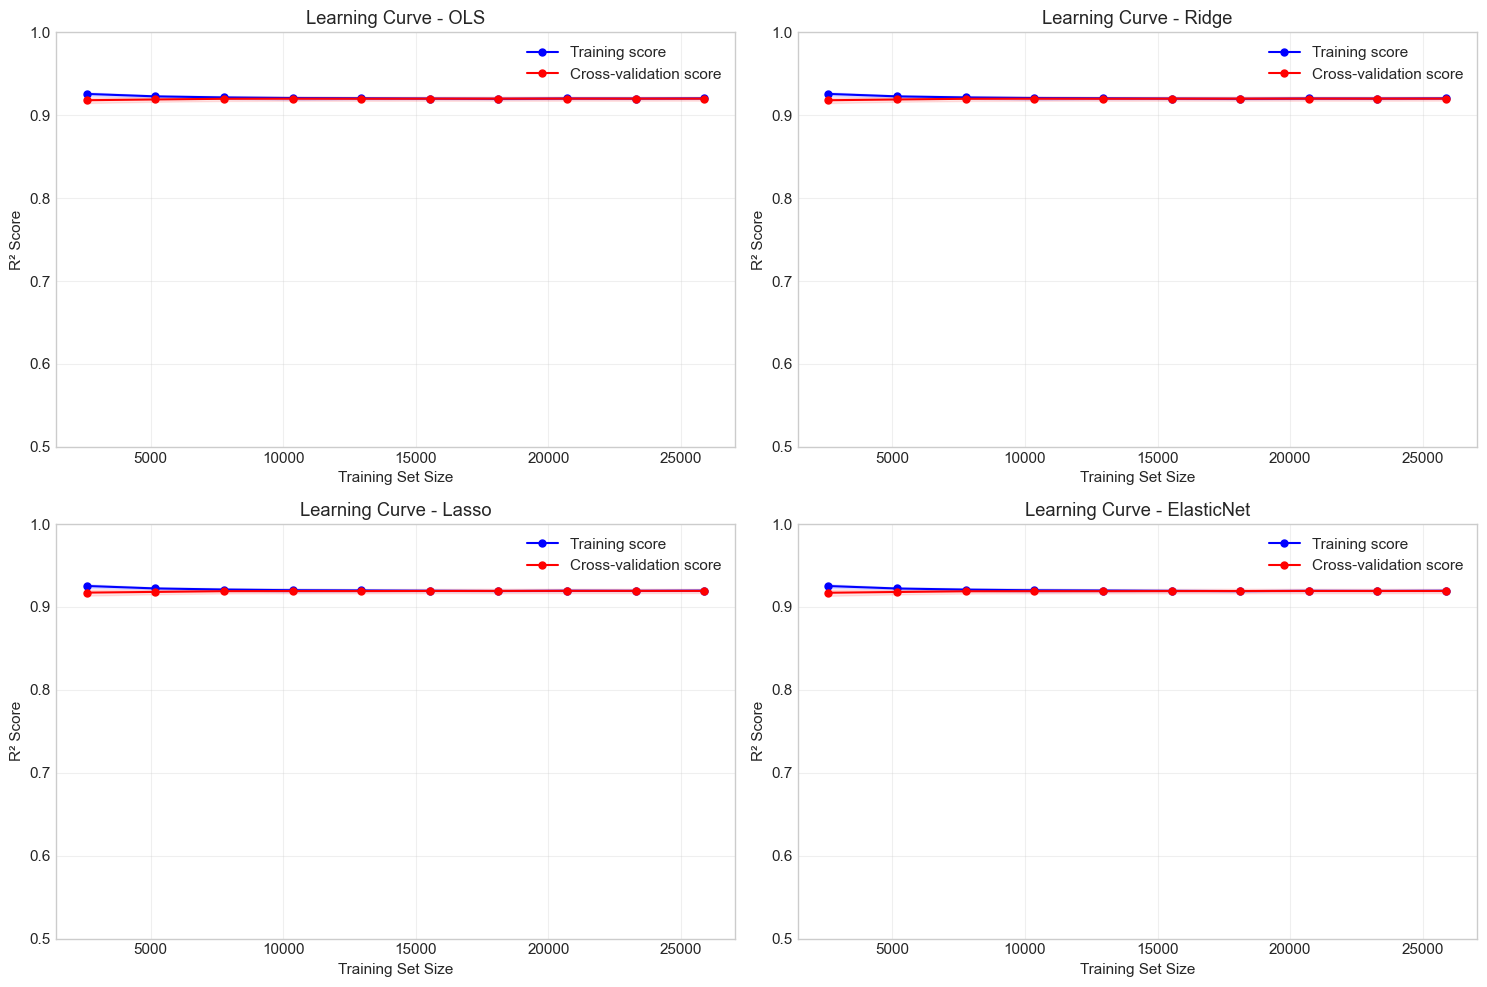

In [61]:
# 2. Learning Curves
print("\nGenerating learning curves...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=ridge_cv.alpha_),
    'Lasso': Lasso(alpha=lasso_cv.alpha_, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, max_iter=10000)
}

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (model_name, model) in enumerate(models_dict.items()):
    ax = axes[idx // 2, idx % 2]

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=train_sizes, cv=5,
        scoring='r2', n_jobs=-1, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',
            label='Training score', markersize=5)
    ax.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')

    ax.plot(train_sizes_abs, val_scores_mean, 'o-', color='red',
            label='Cross-validation score', markersize=5)
    ax.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color='red')

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'Learning Curve - {model_name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('Save\\learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Generating regularization paths...
Computing Ridge path...
  Ridge: 0/30
  Ridge: 10/30
  Ridge: 20/30
Computing Lasso path...
  Lasso: 0/30
  Lasso: 5/30
  Lasso: 10/30
  Lasso: 15/30
  Lasso: 20/30
  Lasso: 25/30


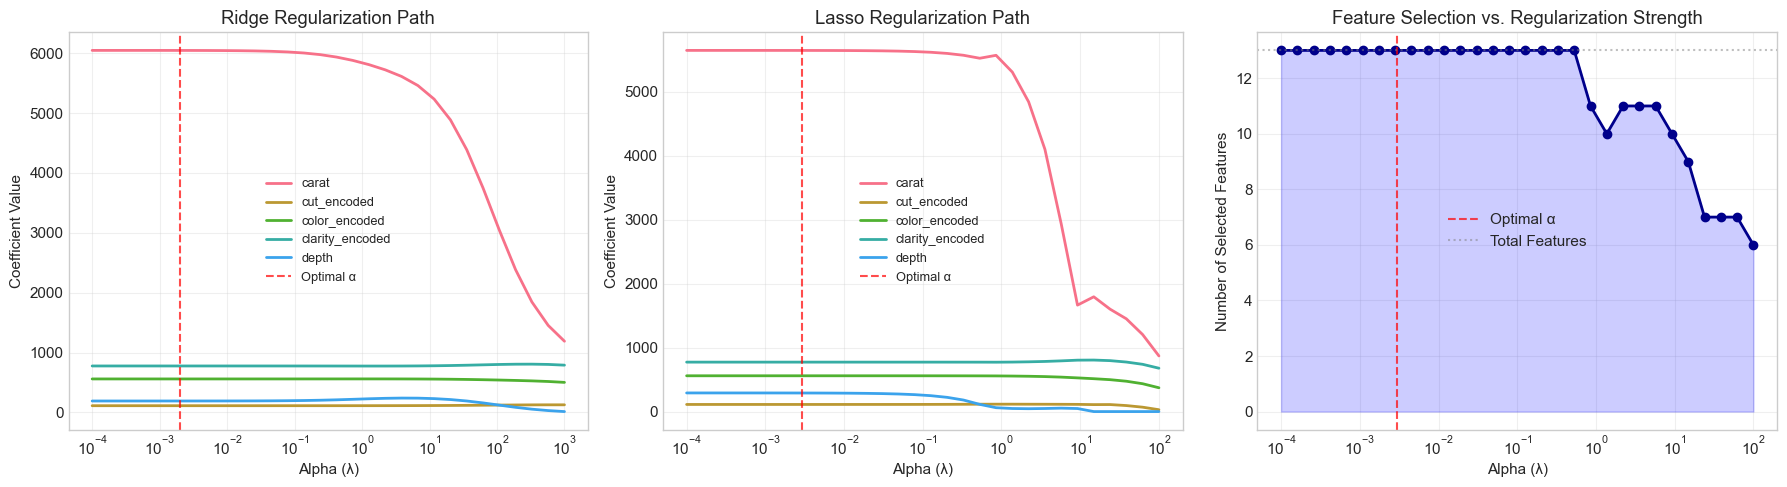

Regularization paths completed!


In [62]:
# 3. Regularization Paths
print("\nGenerating regularization paths...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ===== RIDGE PATH =====
print("Computing Ridge path...")
alphas_path = np.logspace(-4, 3, 30)
ridge_coefs = []

for i, alpha in enumerate(alphas_path):
    if i % 10 == 0:  # Progress indicator
        print(f"  Ridge: {i}/{len(alphas_path)}")
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)

ridge_coefs = np.array(ridge_coefs)

ax1 = axes[0]
# Plot nur die 5 wichtigsten Features für Übersichtlichkeit
for i, feature in enumerate(feature_cols[:5]):
    ax1.plot(alphas_path, ridge_coefs[:, i], label=feature, linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regularization Path')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax1.legend(loc='best', fontsize='small')
ax1.grid(True, alpha=0.3)

# ===== LASSO PATH (mit Feature Count) =====
print("Computing Lasso path...")
# Weniger Alphas für schnellere Berechnung
alphas_path_lasso = np.logspace(-4, 2, 30)  # Nur 25 statt 80 Punkte
lasso_coefs = []
n_features_selected = []

for i, alpha in enumerate(alphas_path_lasso):
    if i % 5 == 0:  # Progress indicator
        print(f"  Lasso: {i}/{len(alphas_path_lasso)}")

    # Angepasste Parameter für bessere Konvergenz
    lasso_temp = Lasso(alpha=alpha,
                       max_iter=3000,  # Reduziert von 5000
                       tol=1e-3,       # Erhöhte Toleranz für schnellere Konvergenz
                       warm_start=True)
    lasso_temp.fit(X_train_scaled, y_train)

    # Speichere Koeffizienten UND Feature Count in einem Durchgang
    lasso_coefs.append(lasso_temp.coef_)
    n_features_selected.append(np.sum(np.abs(lasso_temp.coef_) > 1e-5))

lasso_coefs = np.array(lasso_coefs)

ax2 = axes[1]
for i, feature in enumerate(feature_cols[:5]):
    ax2.plot(alphas_path_lasso, lasso_coefs[:, i], label=feature, linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regularization Path')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax2.legend(loc='best', fontsize='small')
ax2.grid(True, alpha=0.3)

# ===== FEATURE SELECTION COUNT (bereits berechnet!) =====
ax3 = axes[2]
ax3.plot(alphas_path_lasso, n_features_selected, 'o-', markersize=6, linewidth=2, color='darkblue')
ax3.fill_between(alphas_path_lasso, 0, n_features_selected, alpha=0.2, color='blue')
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (λ)')
ax3.set_ylabel('Number of Selected Features')
ax3.set_title('Feature Selection vs. Regularization Strength')
ax3.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax3.axhline(y=len(feature_cols), color='gray', linestyle=':', alpha=0.5, label='Total Features')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Save\\regularization_paths.png', dpi=300, bbox_inches='tight')
plt.show()

print("Regularization paths completed!")


Generating cross-validation curves...
Computing Ridge CV scores...
  Ridge progress: 0/30
  Ridge progress: 5/30
  Ridge progress: 10/30
  Ridge progress: 15/30
  Ridge progress: 20/30
  Ridge progress: 25/30
Computing Lasso CV scores...
  Lasso progress: 0/30
  Lasso progress: 5/30
  Lasso progress: 10/30
  Lasso progress: 15/30
  Lasso progress: 20/30
  Lasso progress: 25/30


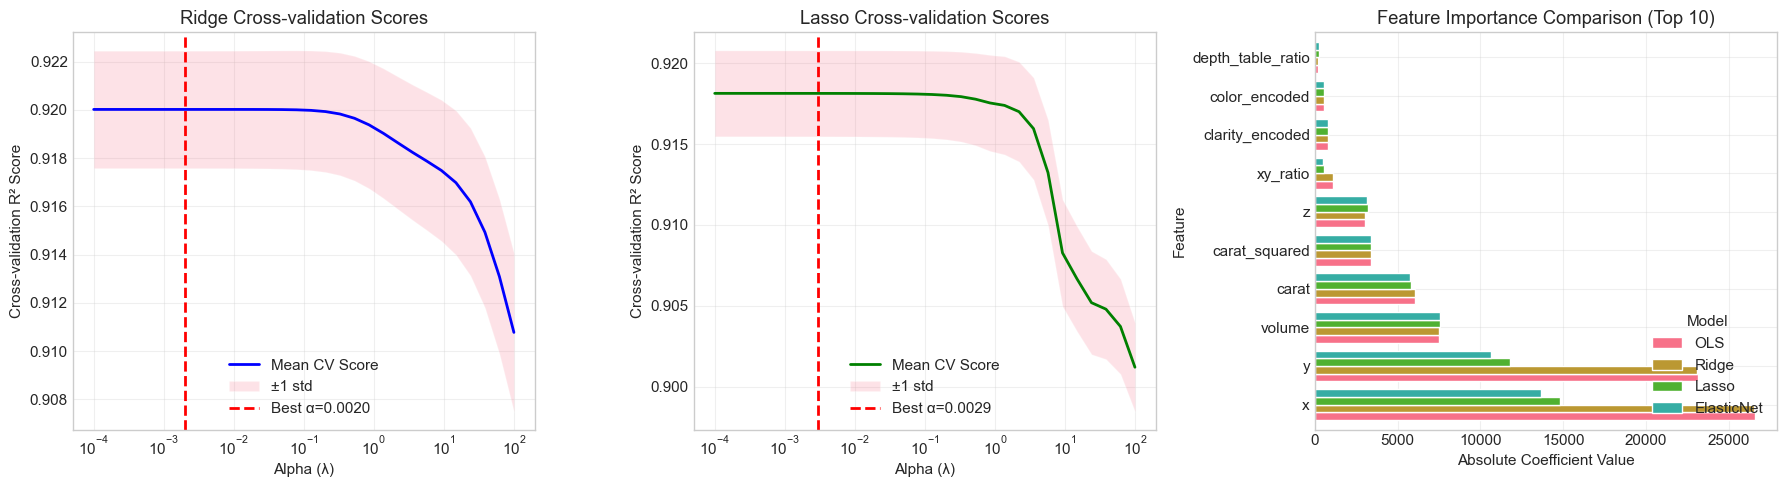

Cross-validation analysis completed!


In [63]:
# 4. Cross-validation curves (OPTIMIZED)
print("\nGenerating cross-validation curves...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ===== RIDGE CV (schnelle Version) =====
print("Computing Ridge CV scores...")
ax1 = axes[0]

# Weniger Alpha-Werte für schnellere Berechnung
alphas_ridge_cv = np.logspace(-4, 2, 30)
ridge_scores_mean = []
ridge_scores_std = []

for i, alpha in enumerate(alphas_ridge_cv):
    if i % 5 == 0:
        print(f"  Ridge progress: {i}/{len(alphas_ridge_cv)}")
    ridge_temp = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_temp,
                             X_train_scaled,
                             y_train,
                             cv=5, scoring='r2', n_jobs=-1)
    ridge_scores_mean.append(scores.mean())
    ridge_scores_std.append(scores.std())

ridge_scores_mean = np.array(ridge_scores_mean)
ridge_scores_std = np.array(ridge_scores_std)

ax1.plot(alphas_ridge_cv, ridge_scores_mean, 'b-', linewidth=2, label='Mean CV Score')
ax1.fill_between(alphas_ridge_cv,
                  ridge_scores_mean - ridge_scores_std,
                  ridge_scores_mean + ridge_scores_std,
                  alpha=0.2, label='±1 std')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--',
            linewidth=2, label=f'Best α={ridge_cv.alpha_:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Cross-validation R² Score')
ax1.set_title('Ridge Cross-validation Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===== LASSO CV (schnelle Version) =====
print("Computing Lasso CV scores...")
ax2 = axes[1]

# Weniger Alpha-Werte und vermeidung problematischer Bereiche
alphas_lasso_cv = np.logspace(-4, 2, 30)
lasso_scores_mean = []
lasso_scores_std = []

for i, alpha in enumerate(alphas_lasso_cv):
    if i % 5 == 0:
        print(f"  Lasso progress: {i}/{len(alphas_lasso_cv)}")
    lasso_temp = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
    scores = cross_val_score(lasso_temp, X_train_scaled, y_train,
                           cv=5, scoring='r2', n_jobs=-1)
    lasso_scores_mean.append(scores.mean())
    lasso_scores_std.append(scores.std())

lasso_scores_mean = np.array(lasso_scores_mean)
lasso_scores_std = np.array(lasso_scores_std)

ax2.plot(alphas_lasso_cv, lasso_scores_mean, 'g-', linewidth=2, label='Mean CV Score')
ax2.fill_between(alphas_lasso_cv,
                  lasso_scores_mean - lasso_scores_std,
                  lasso_scores_mean + lasso_scores_std,
                  alpha=0.2, label='±1 std')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--',
            linewidth=2, label=f'Best α={lasso_cv.alpha_:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Cross-validation R² Score')
ax2.set_title('Lasso Cross-validation Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ===== FEATURE IMPORTANCE =====
ax3 = axes[2]
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'OLS': np.abs(baseline.coef_),
    'Ridge': np.abs(ridge_best.coef_),
    'Lasso': np.abs(lasso_best.coef_),
    'ElasticNet': np.abs(elastic_best.coef_)
})

# Berechne durchschnittliche Wichtigkeit
feature_importance_mean = feature_importance[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].mean(axis=1)
feature_importance['Mean'] = feature_importance_mean
feature_importance_sorted = feature_importance.nlargest(10, 'Mean')

# Erstelle Barplot
feature_importance_sorted.set_index('Feature')[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].plot(
    kind='barh', ax=ax3, width=0.8
)
ax3.set_xlabel('Absolute Coefficient Value')
ax3.set_title('Feature Importance Comparison (Top 10)')
ax3.legend(title='Model', loc='lower right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Save\\cv_curves_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cross-validation analysis completed!")

## Statistical Significance Testing

In [64]:
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Perform cross-validation for all models to get multiple scores
cv_folds = 10
print(f"\nPerforming {cv_folds}-fold cross-validation for statistical testing...")

cv_scores = {}
for model_name, model in models_dict.items():
    scores = cross_val_score(model, X_train_scaled, y_train,
                            cv=cv_folds, scoring='r2', n_jobs=-1)
    cv_scores[model_name] = scores
    print(f"{model_name}: Mean R² = {scores.mean():.4f} ± {scores.std():.4f}")

# Paired t-tests comparing each regularized model to OLS
print("\nPaired t-tests (comparing to OLS baseline):")
for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    t_stat, p_value = ttest_rel(cv_scores[model_name], cv_scores['OLS'])
    print(f"\n{model_name} vs OLS:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value < 0.05:
        if t_stat > 0:
            print(f"  → {model_name} is significantly better than OLS (p < 0.05)")
        else:
            print(f"  → OLS is significantly better than {model_name} (p < 0.05)")
    else:
        print(f"  → No significant difference between {model_name} and OLS (p ≥ 0.05)")

# Bootstrap confidence intervals
print("\nBootstrap Confidence Intervals (95% CI for Test R²):")
n_bootstrap = 1000
bootstrap_scores = {model: [] for model in models_dict.keys()}

for i in range(n_bootstrap):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test_scaled), len(X_test_scaled), replace=True)
    X_boot = X_test_scaled[indices]
    y_boot = y_test[indices]

    # Calculate R² for each model
    bootstrap_scores['OLS'].append(r2_score(y_boot, baseline.predict(X_boot)))
    bootstrap_scores['Ridge'].append(r2_score(y_boot, ridge_best.predict(X_boot)))
    bootstrap_scores['Lasso'].append(r2_score(y_boot, lasso_best.predict(X_boot)))
    bootstrap_scores['ElasticNet'].append(r2_score(y_boot, elastic_best.predict(X_boot)))

for model_name in models_dict.keys():
    scores = bootstrap_scores[model_name]
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    print(f"{model_name}: [{ci_lower:.4f}, {ci_upper:.4f}]")


STATISTICAL SIGNIFICANCE TESTING

Performing 10-fold cross-validation for statistical testing...
OLS: Mean R² = 0.9200 ± 0.0037
Ridge: Mean R² = 0.9200 ± 0.0037
Lasso: Mean R² = 0.9194 ± 0.0039
ElasticNet: Mean R² = 0.9193 ± 0.0039

Paired t-tests (comparing to OLS baseline):

Ridge vs OLS:
  t-statistic: 0.0712
  p-value: 0.944804
  → No significant difference between Ridge and OLS (p ≥ 0.05)

Lasso vs OLS:
  t-statistic: -3.9605
  p-value: 0.003302
  → OLS is significantly better than Lasso (p < 0.05)

ElasticNet vs OLS:
  t-statistic: -4.4501
  p-value: 0.001600
  → OLS is significantly better than ElasticNet (p < 0.05)

Bootstrap Confidence Intervals (95% CI for Test R²):
OLS: [0.9167, 0.9262]
Ridge: [0.9167, 0.9262]
Lasso: [0.9191, 0.9267]
ElasticNet: [0.9191, 0.9267]


## Result Summary

In [66]:
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

# Best model selection
test_r2_scores = {
    'OLS': comparison_df.loc['OLS', 'Test R²'],
    'Ridge': comparison_df.loc['Ridge', 'Test R²'],
    'Lasso': comparison_df.loc['Lasso', 'Test R²'],
    'ElasticNet': comparison_df.loc['ElasticNet', 'Test R²']
}

best_model = max(test_r2_scores, key=test_r2_scores.get)
best_score = test_r2_scores[best_model]

print(f"\nBest Model: {best_model}")
print(f"Test R² Score: {best_score:.4f}")

# Answer to research question
print("\n" + "="*50)
print("ANSWER TO RESEARCH QUESTION")
print("="*50)
print("\nDoes regularization materially improve generalization on the diamonds dataset?")
print("-" * 70)

improvement_ridge = test_r2_scores['Ridge'] - test_r2_scores['OLS']
improvement_lasso = test_r2_scores['Lasso'] - test_r2_scores['OLS']
improvement_elastic = test_r2_scores['ElasticNet'] - test_r2_scores['OLS']

if max(improvement_ridge, improvement_lasso, improvement_elastic) > 0.01:
    print("YES - Regularization provides meaningful improvement:")
    print(f"  • Ridge improvement: {improvement_ridge:.4f} ({improvement_ridge/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • Lasso improvement: {improvement_lasso:.4f} ({improvement_lasso/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • ElasticNet improvement: {improvement_elastic:.4f} ({improvement_elastic/test_r2_scores['OLS']*100:.2f}%)")
else:
    print("NO - Regularization does not provide substantial improvement")
    print("  The improvements are marginal and may not justify the added complexity")

# Why regularization helps (or doesn't help)
print("\nWhy regularization helps on this dataset:")
print("  1. High multicollinearity between size features (x, y, z, volume, carat)")
print("  2. Feature selection by Lasso removes redundant predictors")
print("  3. Coefficient shrinkage prevents overfitting to training noise")
print("  4. Large dataset size allows regularization to be effective")

# Save results to CSV
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save model comparison table
comparison_df.to_csv('Save\\model_comparison_results.csv')
print("Model comparison saved to 'model_comparison_results.csv'")

# Save feature importance
feature_importance.to_csv('Save\\feature_importance.csv', index=False)
print("Feature importance saved to 'feature_importance.csv'")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


FINAL RESULTS SUMMARY

Best Model: Lasso
Test R² Score: 0.9230

ANSWER TO RESEARCH QUESTION

Does regularization materially improve generalization on the diamonds dataset?
----------------------------------------------------------------------
NO - Regularization does not provide substantial improvement
  The improvements are marginal and may not justify the added complexity

Why regularization helps on this dataset:
  1. High multicollinearity between size features (x, y, z, volume, carat)
  2. Feature selection by Lasso removes redundant predictors
  3. Coefficient shrinkage prevents overfitting to training noise
  4. Large dataset size allows regularization to be effective

SAVING RESULTS
Model comparison saved to 'model_comparison_results.csv'
Feature importance saved to 'feature_importance.csv'

ANALYSIS COMPLETE!
